In [4]:
!pip install tensorflow==2.13.0
!pip install ampligraph
!pip install rdflib

  Using cached typing_extensions-4.5.0-py3-none-any.whl.metadata (8.5 kB)
Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.15.0
    Uninstalling typing_extensions-4.15.0:
      Successfully uninstalled typing_extensions-4.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
exceptiongroup 1.3.1 requires typing-extensions>=4.6.0; python_version < "3.13", but you have typing-extensions 4.5.0 which is incompatible.

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
Using cached typing_extensions-4.15.0-py3-none-any.whl (44 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
 

In [5]:
import numpy as np
import pandas as pd
import ampligraph
import tensorflow as tf
from rdflib import Graph

In [6]:
owl_file_name = "/Users/m.s.taranenko/PyCharmMiscProject/wot_with_data.owl"
g = Graph()
g.parse(owl_file_name)

# Извлекаем все триплеты
triplets = []
for subj, pred, obj in g:
  triplets.append((
    str(subj),
    str(pred),
    str(obj)
  ))

# Создаем DataFrame
df = pd.DataFrame(triplets, columns=['subject', 'predicate', 'object'])

In [7]:
from ampligraph.evaluation import train_test_split_no_unseen

X_train, X_valid = train_test_split_no_unseen(np.array(df), test_size=3000)

In [8]:
from ampligraph.latent_features import ScoringBasedEmbeddingModel
from ampligraph.latent_features.loss_functions import get as get_loss
from ampligraph.latent_features.regularizers import get as get_regularizer

model = ScoringBasedEmbeddingModel(k=100,
                                   eta=20,
                                   scoring_type='ComplEx',
                                   seed=0)

# Optimizer, loss and regularizer definition
loss = get_loss('multiclass_nll')

# Compilation of the model
model.compile(optimizer="adam", loss=loss)

In [9]:
model.fit(X_train,
          batch_size=int(X_train.shape[0] / 50),
          epochs=300, # Number of training epochs
          verbose=True # Displays a progress bar.
          )

Epoch 1/300
52/52 [==============================] - 1s 25ms/step - loss: 1678.3521
Epoch 2/300
52/52 [==============================] - 1s 13ms/step - loss: 1677.3011
Epoch 3/300
52/52 [==============================] - 1s 14ms/step - loss: 1670.7784
Epoch 4/300
52/52 [==============================] - 1s 15ms/step - loss: 1644.4646
Epoch 5/300
52/52 [==============================] - 1s 14ms/step - loss: 1583.7009
Epoch 6/300
52/52 [==============================] - 1s 14ms/step - loss: 1496.1819
Epoch 7/300
52/52 [==============================] - 1s 15ms/step - loss: 1399.7314
Epoch 8/300
52/52 [==============================] - 1s 15ms/step - loss: 1304.4127
Epoch 9/300
52/52 [==============================] - 1s 15ms/step - loss: 1214.3224
Epoch 10/300
52/52 [==============================] - 1s 15ms/step - loss: 1131.1851
Epoch 11/300
52/52 [==============================] - 1s 14ms/step - loss: 1055.7516
Epoch 12/300
52/52 [==============================] - 1s 14ms/step - loss:

In [10]:
ranks = model.evaluate(X_valid,
                      use_filter={'train': X_train,
                                  'test': X_valid},
                      corrupt_side='s,o',
                      verbose=True)

301/301 [==============================] - 4s 14ms/step


In [11]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.41
MR: 608.91
Hits@10: 0.56
Hits@3: 0.44
Hits@1: 0.33


# Разбиение по нациям

In [23]:
def import_tanks_from_wot_data_as_dataframe():
    """
    Импортирует данные о танках из wot_data.csv и возвращает pandas DataFrame.
    Аналог original функции, но без RDF, только структурированный датасет.
    """
    import pandas as pd
    from pathlib import Path

    print("\n" + "=" * 60)
    print("IMPORTING TANK DATA FROM wot_data.csv → DATAFRAME")
    print("=" * 60)

    wot_data_file = "wot_data.csv"

    # Читаем данные
    df = pd.read_csv(wot_data_file, sep=';')
    print(f"Loaded {len(df)} tank configurations")

    # Маппинг типа → роль (как в оригинальной функции)
    def get_role_name_from_type(tank_type):
        role_map = {
            'HeavyTank': 'HeavyAssault',
            'MediumTank': 'Support',
            'LightTank': 'Scout',
            'SPG': 'Artillery',
            'AT-SPG': 'Sniper'
        }
        return role_map.get(tank_type, 'General')

    # Группируем по имени танка — берём первую конфигурацию (или агрегируем)
    print(f"Creating unique tank entries...")
    tanks_unique = df.groupby('name').first().reset_index()

    # Список для результирующих данных
    tank_data = []

    for idx, row in tanks_unique.iterrows():
        tank_name = row['name'].strip()

        # Базовые атрибуты
        tank_dict = {
            'name': tank_name,
            'tier': pd.to_numeric(row.get('tier'), errors='coerce'),
            'nation': row.get('nation'),
            'type': row.get('type', 'Tank'),
            'is_premium': bool(row.get('is_premium', False)),
            'is_wheeled': bool(row.get('is_wheeled', False)),
            'is_gift': bool(row.get('is_gift', False)),
            'short_name': row.get('short_name'),
            'price_credit': pd.to_numeric(row.get('price_credit'), errors='coerce'),
            'price_gold': pd.to_numeric(row.get('price_gold'), errors='coerce'),
        }

        # Характеристики
        tank_dict.update({
            'hp': pd.to_numeric(row.get('hp'), errors='coerce'),
            'hull_hp': pd.to_numeric(row.get('hull_hp'), errors='coerce'),
            'weight': pd.to_numeric(row.get('weight'), errors='coerce'),
            'hull_weight': pd.to_numeric(row.get('hull_weight'), errors='coerce'),
            'speed_forward': pd.to_numeric(row.get('speed_forward'), errors='coerce'),
            'speed_backward': pd.to_numeric(row.get('speed_backward'), errors='coerce'),
            'ammo.avg_damage': pd.to_numeric(row.get('ammo.avg_damage'), errors='coerce'),
            'ammo.avg_penetration': pd.to_numeric(row.get('ammo.avg_penetration'), errors='coerce'),
            'dpm': pd.to_numeric(row.get('dpm'), errors='coerce'),
            'gun.fire_rate': pd.to_numeric(row.get('gun.fire_rate'), errors='coerce'),
            'gun.aim_time': pd.to_numeric(row.get('gun.aim_time'), errors='coerce'),
        })

        # Роль на основе типа
        tank_dict['role'] = get_role_name_from_type(tank_dict['type'])

        # ID модулей (для возможной агрегации позже)
        tank_dict.update({
            'gun_id': row.get('gun'),
            'engine_id': row.get('engine'),
            'turret_id': row.get('turret'),
            'suspension_id': row.get('suspension'),
            'radio_id': row.get('radio'),
        })

        tank_data.append(tank_dict)


    # Создаём DataFrame
    result_df = pd.DataFrame(tank_data)

    # Необязательно: удаляем строки с пропущенным именем
    result_df = result_df.dropna(subset=['name']).reset_index(drop=True)


    return result_df

In [24]:
df_tanks = import_tanks_from_wot_data_as_dataframe()


IMPORTING TANK DATA FROM wot_data.csv → DATAFRAME
Loaded 14691 tank configurations
Creating unique tank entries...


ARS : 0.065
WARNING - Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


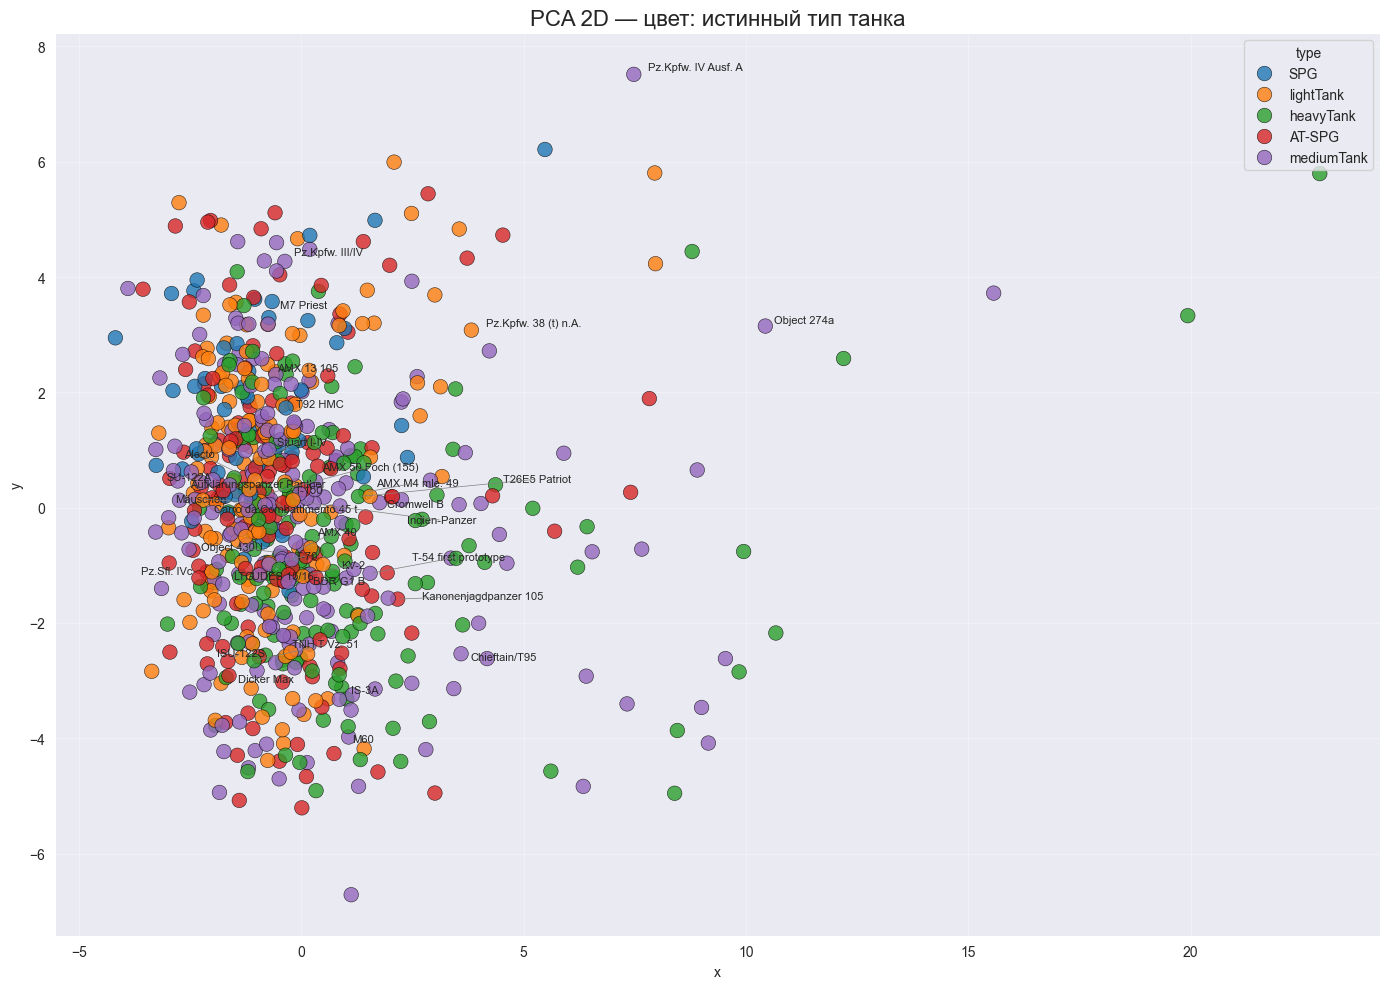

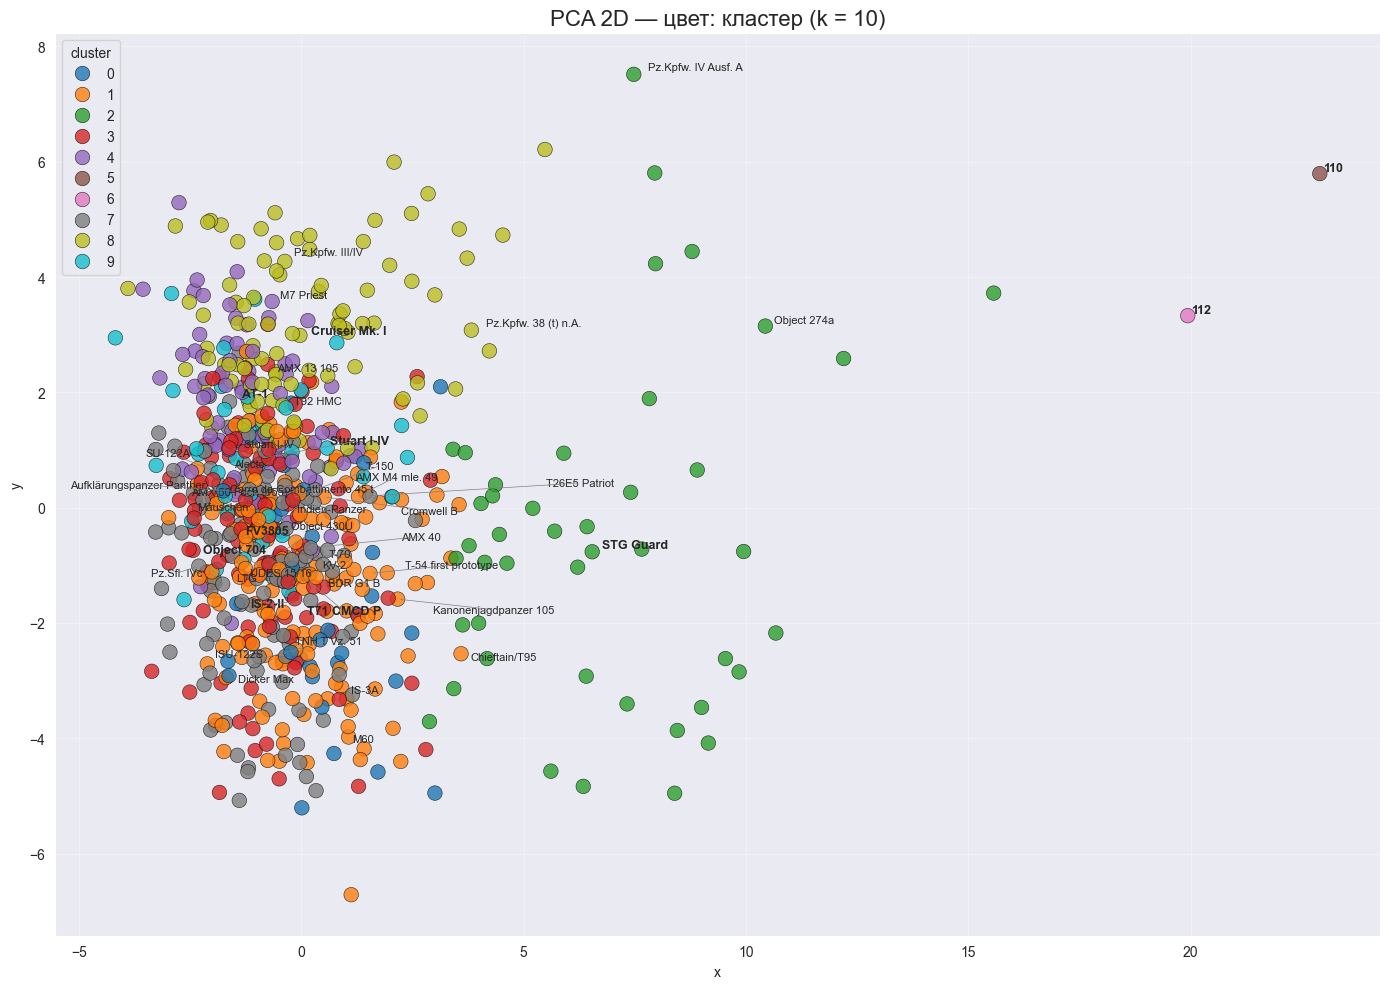

In [14]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

tanks = df_tanks['name'].values
y_true = df_tanks.set_index('name').loc[tanks, 'type'].values

X = model.get_embeddings(tanks)

X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=0.90, random_state=42)
X_pca = pca.fit_transform(X_scaled)


k = 10

kmeans = KMeans(
    n_clusters=k,
    n_init=50,
    max_iter=500,
    random_state=42
)

clusters = kmeans.fit_predict(X_pca)

arc = adjusted_rand_score(y_true, clusters)

print(f"ARS : {arc:.3f}")

pca_2d = PCA(n_components=2, random_state=42)
X_2d = pca_2d.fit_transform(X_scaled)


plot_df = pd.DataFrame({
    "name": tanks,
    "x": X_2d[:, 0],
    "y": X_2d[:, 1],
    "type": y_true,
    "cluster": clusters
})

def plot_embeddings(
    df,
    hue,
    title,
    label_frac=0.05,
    figsize=(14, 10)
):
    np.random.seed(42)
    plt.figure(figsize=figsize)

    ax = sns.scatterplot(
        data=df,
        x="x",
        y="y",
        hue=hue,
        palette="tab10" if df[hue].nunique() <= 10 else "tab20",
        s=110,
        alpha=0.8,
        edgecolor="black",
        linewidth=0.4
    )

    texts = []

    # 1. Центры кластеров
    if hue == "cluster":
        centers = df.groupby("cluster")[["x", "y"]].mean().reset_index()
        for _, c in centers.iterrows():
            nearest = df.iloc[
                ((df["x"] - c["x"])**2 + (df["y"] - c["y"])**2).idxmin()
            ]
            texts.append(
                plt.text(nearest["x"], nearest["y"], nearest["name"],
                         fontsize=9, fontweight="bold")
            )

    # 2. Случайная подвыборка
    sample = df.sample(frac=label_frac, random_state=42)
    for _, row in sample.iterrows():
        texts.append(
            plt.text(row["x"], row["y"], row["name"], fontsize=8)
        )

    adjust_text(
        texts,
        arrowprops=dict(arrowstyle="-", color="gray", lw=0.5),
        force_text=0.5,
        expand_points=(1.2, 1.2)
    )

    plt.title(title, fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_embeddings(
    plot_df,
    hue="type",
    title="PCA 2D — цвет: истинный тип танка"
)

plot_embeddings(
    plot_df,
    hue="cluster",
    title="PCA 2D — цвет: кластер (k = 10)"
)



# Классификация

In [15]:
!pip uninstall -y xgboost
!pip install xgboost


Found existing installation: xgboost 2.1.4
Uninstalling xgboost-2.1.4:
  Successfully uninstalled xgboost-2.1.4
  Using cached xgboost-2.1.4-py3-none-macosx_12_0_arm64.whl.metadata (2.1 kB)
Using cached xgboost-2.1.4-py3-none-macosx_12_0_arm64.whl (1.9 MB)

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [16]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder

In [17]:

tanks = df_tanks['name'].values

X = model.get_embeddings(tanks)

y_raw = df_tanks.set_index('name').loc[tanks, 'type'].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)


In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

In [20]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="multi:softmax",
    num_class=len(label_encoder.classes_),
    random_state=42,
    eval_metric="mlogloss"
)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

acc_xgb = accuracy_score(y_test, y_pred)
print(f"XGBoost accuracy (KG embeddings): {acc_xgb:.3f}")

XGBoost accuracy (KG embeddings): 0.768


In [146]:
from collections import Counter

most_common_class = Counter(y_train).most_common(1)[0][0]
y_pred_base = np.full_like(y_test, most_common_class)

acc_base = accuracy_score(y_test, y_pred_base)
print(f"Baseline (most frequent class) accuracy: {acc_base:.3f}")


Baseline (most frequent class) accuracy: 0.299


In [147]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Данные для one-hot baseline
df_features = df_tanks.set_index('name').loc[tanks][['nation', 'tier', 'role']]

X_train_feat, X_test_feat, y_train_feat, y_test_feat = train_test_split(
    df_features,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

categorical_features = ['nation', 'role']
numeric_features = ['tier']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numeric_features)
    ]
)

baseline_model = Pipeline([
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(max_iter=1000))
])

baseline_model.fit(X_train_feat, y_train_feat)

y_pred_oh = baseline_model.predict(X_test_feat)
acc_oh = accuracy_score(y_test_feat, y_pred_oh)

print(f"Baseline (one-hot features) accuracy: {acc_oh:.3f}")


Baseline (one-hot features) accuracy: 0.650


In [148]:
import numpy as np
import pandas as pd
from tqdm import tqdm


In [149]:
# Все сущности типа tank
tank_entities = set(df_tanks['name'].values)

In [154]:
ranks = []

def evaluate_triple_rank(model, triple, tank_entities):
    h, r, t_true = triple

    # Генерируем негативные tail-сущности
    negative_tails = list(tank_entities - {t_true})

    # Формируем негативные триплеты
    negative_triples = np.array([[h, r, t] for t in negative_tails])

    # Полный список: истинный + негативные
    all_triples = np.vstack([
        np.array([[h, r, t_true]]),
        negative_triples
    ])

    # Получаем score модели
    scores = model.predict(all_triples)

    # Сортировка по убыванию score
    ranked_indices = np.argsort(scores)[::-1]

    # Ранг истинного триплета (позиция +1)
    rank = np.where(ranked_indices == 0)[0][0] + 1

    return rank

for triple in tqdm(X_valid):
    h, r, t = triple
    if t in tank_entities:
        rank = evaluate_triple_rank(model, triple, tank_entities)
        ranks.append(rank)

ranks = np.array(ranks)


100%|██████████| 3000/3000 [00:04<00:00, 658.00it/s]


In [155]:
mr = ranks.mean()
print(f"MR: {mr:.2f}")

mrr = np.mean(1.0 / ranks)
print(f"MRR: {mrr:.3f}")

def hits_at_n(ranks, n):
    return np.mean(ranks <= n)

for n in [1, 3, 10]:
    print(f"Hits@{n}: {hits_at_n(ranks, n):.3f}")


MR: 20.25
MRR: 0.845
Hits@1: 0.767
Hits@3: 0.922
Hits@10: 0.957


# Предсказание ссылок (hasType)

In [157]:
ranks = []

types = {"http://www.semanticweb.org/ontology/wot#SelfPropelledGun",
         "http://www.semanticweb.org/ontology/wot#HeavyTank",
         "http://www.semanticweb.org/ontology/wot#MediumTank",
         "http://www.semanticweb.org/ontology/wot#LightTank",
         "http://www.semanticweb.org/ontology/wot#TankDestroyer"}


def evaluate_triple_rank(model, triple):
    h, r, t_true = triple

    negative_tails = list(types - {t_true})

    negative_triples = np.array([[h, r, t] for t in negative_tails])

    all_triples = np.vstack([
        np.array([[h, r, t_true]]),
        negative_triples
    ])

    scores = model.predict(all_triples)

    ranked_indices = np.argsort(scores)[::-1]

    rank = np.where(ranked_indices == 0)[0][0] + 1

    return rank


for triple in tqdm(X_valid):
    h, r, t = triple
    if t in types:
        rank = evaluate_triple_rank(model, triple)
        ranks.append(rank)

ranks = np.array(ranks)

mr = ranks.mean()
print(f"MR: {mr:.2f}")

mrr = np.mean(1.0 / ranks)
print(f"MRR: {mrr:.3f}")


def hits_at_n(ranks, n):
    return np.mean(ranks <= n)


for n in [1, 3, 10]:
    print(f"Hits@{n}: {hits_at_n(ranks, n):.3f}")

100%|██████████| 3000/3000 [00:00<00:00, 15666.78it/s]

MR: 1.00
MRR: 1.000
Hits@1: 1.000
Hits@3: 1.000
Hits@10: 1.000
